# AI Lab Run Hiddim Investigation
This currently involve plotting the 

@25

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE   # one type of clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from itertools import combinations

In [2]:
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import SimplerPhxLearnerInit as TheLearner
from model_dataset import WordDatasetPath as ThisDataset
from model_dataset import Normalizer, DeNormalizer
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import WordEncodeResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut, ARPABET

## Preps

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Prepare for loading Model

In [5]:
ts = "0129210506"
stop_epoch = "25"
train_name = "A_01"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
assert PU.path_exist(model_save_dir)
print(f"{train_name}-{ts}")

A_01-0129210506


## Load Dataset

In [6]:
TEST = False

In [7]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       transform=mytrans)

valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


# Load Test set
if TEST: 
    test_ds = ThisDataset(rec_dir, 
                        test_guide_path, 
                        transform=mytrans)
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))

    use_test_ds = torch.utils.data.Subset(test_ds, test_ds_indices)

    test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    test_num = len(test_loader.dataset)

## Model

### Model-related defs

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [9]:
model_name = "{}.pt".format(stop_epoch)
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

SimplerPhxLearnerInit(
  (encoder): RLEncoder(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=8, bias=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): InitRALDecoder(
    (rnn): LSTM(64, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=8, out_features=64, bias=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
)

## Inference

In [10]:
def infer(): 
    model.eval()
    reshandler = WordEncodeResHandler(whole_res_dir=model_save_dir, 
                                 file_prefix=f"encode-{stop_epoch}")
    all_res = []
    all_name = []

    for (x, x_lens, name) in tqdm(valid_loader): 
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r = model.encode(x, x_lens, x_mask)

        hid_r = hid_r.cpu().detach().numpy().squeeze()

        all_res += [hid_r]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_name += [name]
    

    reshandler.res = all_res
    reshandler.name = all_name
    reshandler.save()

In [11]:
if __name__ == "__main__": 
    infer()

100%|██████████| 10380/10380 [00:23<00:00, 443.59it/s]


# Load Res

In [12]:
reshandler = WordEncodeResHandler(whole_res_dir=model_save_dir, file_prefix=f"encode-{stop_epoch}")
reshandler.read()

# Plot some recon and original comparisons

In [13]:
# all
all_res = reshandler.res
all_name = reshandler.name

# read in guide file
guide_file = pd.read_csv(valid_guide_path)
# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]
filtered_df = guide_file[guide_file['wuid'].isin(all_name)].copy()

filtered_df["startFrame"] = filtered_df.apply(lambda x: time_to_frame(x['startTime'] - x['word_startTime']), axis=1)
filtered_df["endFrame"] = filtered_df.apply(lambda x: time_to_frame(x['endTime'] - x['word_startTime']), axis=1)

In [14]:
name_dict = {token: index for index, token in enumerate(all_name)}

In [15]:
def cutHid(hid, cutstart, cutend): 
    # hid is (L, H)
    return hid[cutstart:cutend, :]

In [16]:
def get_toplot(data, name_dict, df, selector, max_counts=500): 
    selected_df = pd.DataFrame(columns=df.columns)
    for item in selector:
        # Filter the DataFrame for the current item
        filtered_df = df[df['segment_nostress'] == item]
        
        # Check if the number of rows exceeds the maximum count
        if len(filtered_df) > max_counts:
            # Randomly sample max_counts[item] rows
            sampled_df = filtered_df.sample(n=max_counts, replace=False)
        else:
            sampled_df = filtered_df
        # Append to the selected_df
        selected_df = pd.concat([selected_df, sampled_df], axis=0)
    # selected_df = df[df["segment_nostress"].isin(cluster_groups)]
    selected_wuid = selected_df["wuid"].tolist()
    indices = [name_dict[token] for token in selected_wuid]
    selected_items = []
    for idx in indices: 
        selected_items.append(data[idx])
    cutstarts = selected_df["startFrame"]
    cutends = selected_df["endFrame"]

    hid_sel = np.empty((0, 8))
    tag_sel = []
    for (item, start, end, tag) in zip(selected_items, cutstarts, cutends, selected_df["segment_nostress"]): 
        hid = cutHid(item, start, end)
        hidlen = hid.shape[0]
        hid_sel = np.concatenate((hid_sel, hid), axis=0)
        tag_sel += [tag] * hidlen
    return hid_sel, np.array(tag_sel)

### Multiplot by Phoneme

In [17]:
# get usable cluster groups
cluster_groups = ["L", "HH"]

hidr_cs, tags_cs = get_toplot(data=all_res, 
                              name_dict=name_dict, 
                              df=filtered_df, 
                              selector=cluster_groups, 
                              max_counts=500)

color_translate = {item: idx for idx, item in enumerate(cluster_groups)}

# Use Counter to count the occurrences of each item
item_counts = Counter(tags_cs)

# Print the item counts
for item, count in item_counts.items():
    print(f"{item}: {count}")

L: 3126
HH: 2920


/tmp/ipykernel_478921/3088263589.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_df = pd.concat([selected_df, sampled_df], axis=0)


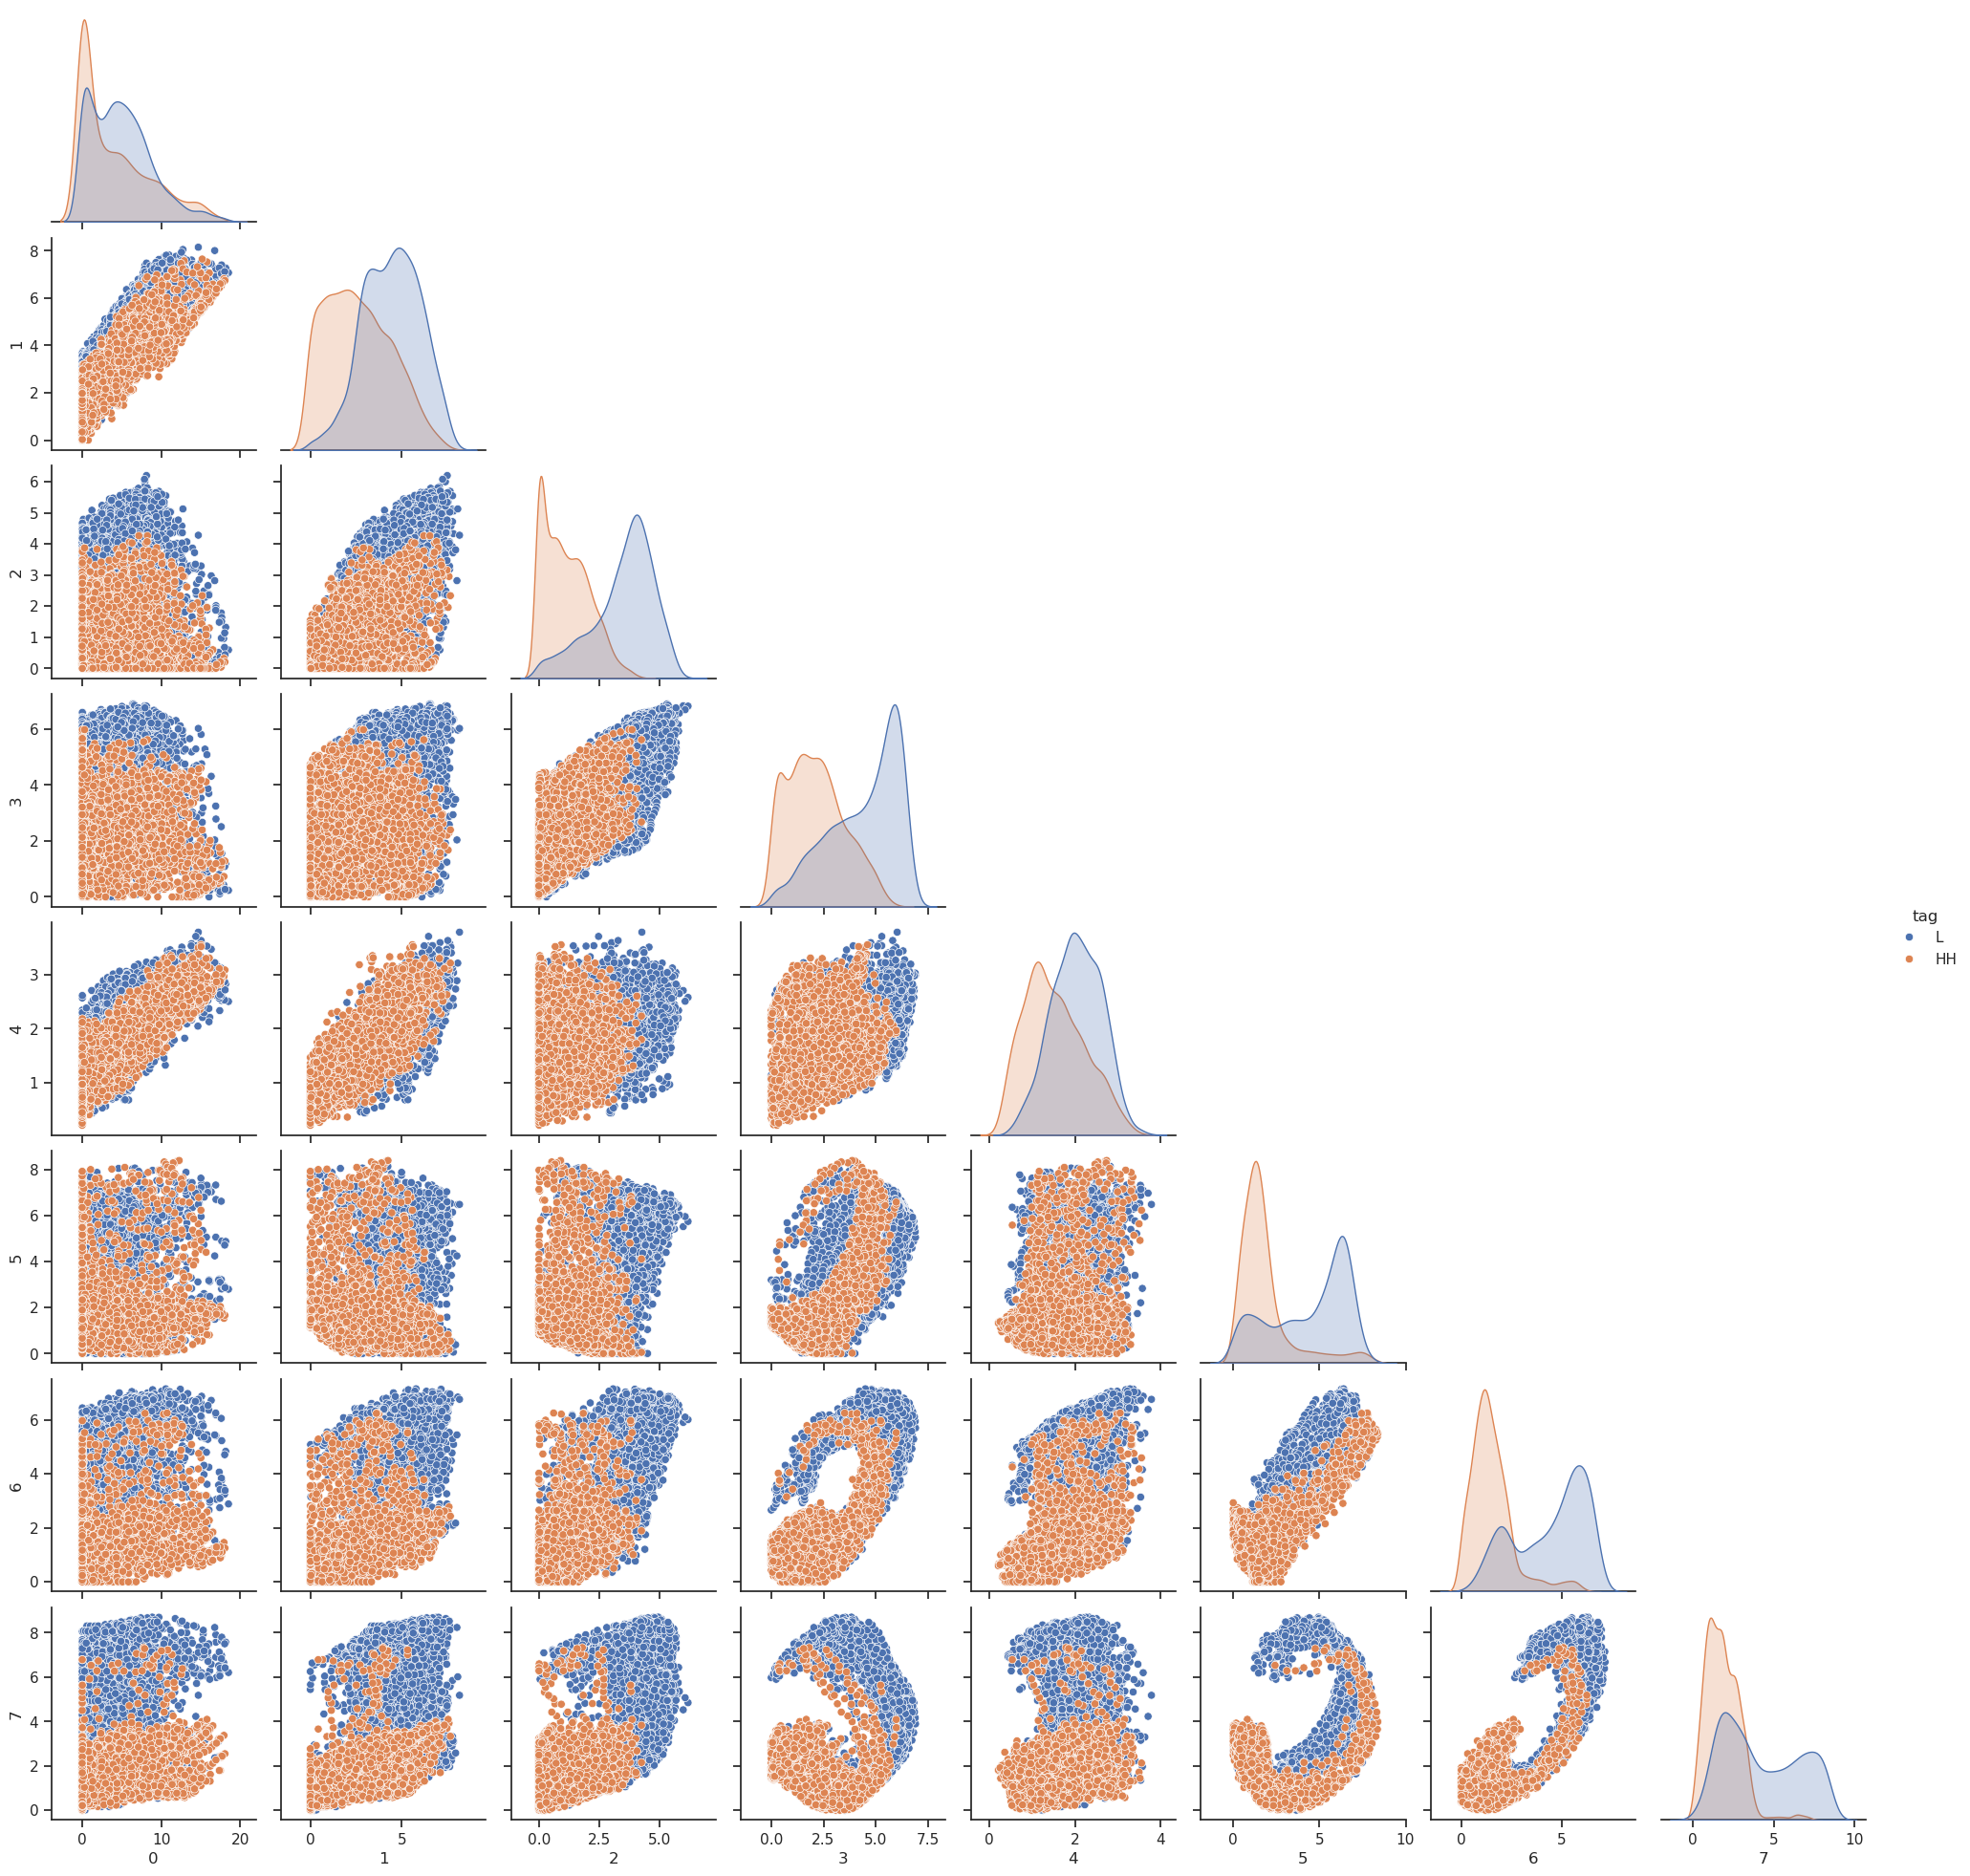

In [18]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='tag', corner=True, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")

In [19]:
# Number of clusters
n_clusters = len(cluster_groups)

# Running KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X)


/home/franklhtan/anaconda3/envs/wavln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
silhouette_avg = silhouette_score(X, tags_cs)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.21657377026508493


In [21]:
adjusted_rand_score(tags_cs, cluster_labels)

0.09550313251457802

In [22]:
v_measure_score(tags_cs, cluster_labels)

0.0734612796775792

## Corr

In [23]:
def dataframe_to_phonological_dict(df):
    phonological_dict = {}
    for index, row in df.iterrows():
        symbol = row['ARPABET']
        phonological_vector = np.array(row.iloc[3:], dtype=int)
        phonological_dict[symbol] = phonological_vector
    return phonological_dict

In [24]:
def edit_dist(a, b): 
    # a, b being numpy arrays
    return np.sum(a != b)

In [25]:
mapper = pd.read_csv("./english_to_feats.csv")
mapper = mapper[mapper["ARPABET"].notna()]

In [26]:
mapperdict = dataframe_to_phonological_dict(mapper)

In [27]:
all_v = filtered_df[filtered_df["segment_nostress"].isin(ARPABET.list_vowels())]["segment_nostress"].unique().tolist()
all_c = filtered_df[filtered_df["segment_nostress"].isin(ARPABET.list_consonants())]["segment_nostress"].unique().tolist()

In [28]:
ssc = [] # silhouette score
eds = []

for (a, b) in list(combinations(all_v, 2)) + list(combinations(all_c, 2)): 
    X, Y = get_toplot(data=all_res, 
                              name_dict=name_dict, 
                              df=filtered_df, 
                              selector=[a, b], 
                              max_counts=500)
    
    ssc.append(silhouette_score(X, Y))
    eds.append(edit_dist(mapperdict[a], mapperdict[b]))

/tmp/ipykernel_478921/3088263589.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_df = pd.concat([selected_df, sampled_df], axis=0)


/tmp/ipykernel_478921/3088263589.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_df = pd.concat([selected_df, sampled_df], axis=0)
/tmp/ipykernel_478921/3088263589.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_df = pd.concat([selected_df, sampled_df], axis=0)
/tmp/ipykernel_478921/3088263589.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

In [29]:
correlation_matrix = np.corrcoef(ssc, eds)
correlation = correlation_matrix[0, 1]
print(f"Pearson's correlation coefficient: {correlation}")


Pearson's correlation coefficient: 0.3461193442929227


In [30]:
alltoken_out = pd.DataFrame({"edit_dist": eds, "silhouette": ssc})

<Axes: xlabel='edit_dist', ylabel='silhouette'>

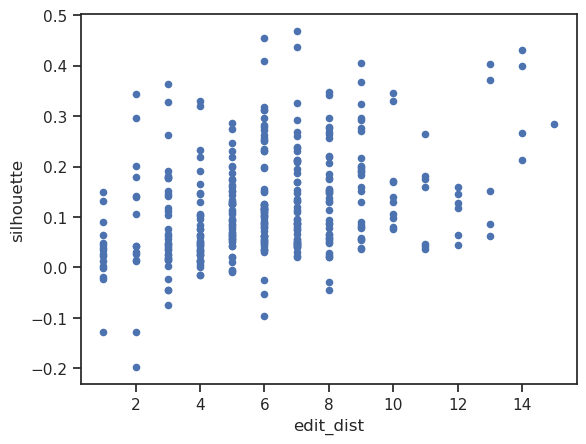

In [31]:
alltoken_out.plot(x='edit_dist', y='silhouette', kind='scatter')

In [32]:
alltoken_out[["edit_dist", "silhouette"]].corr()

,edit_dist,silhouette
edit_dist,1.000000,0.346119
silhouette,0.346119,1.000000


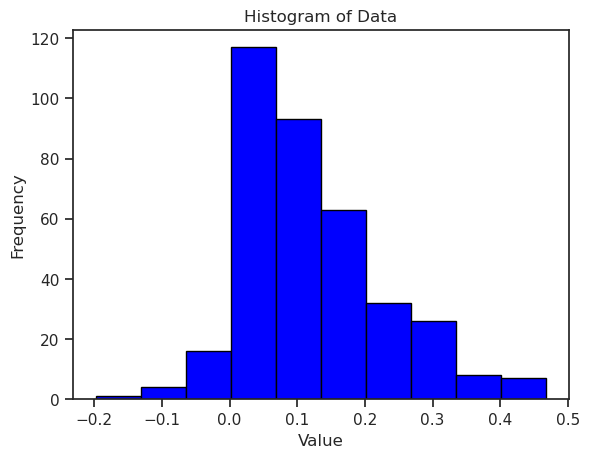

In [33]:
# Creating the histogram
plt.hist(ssc, bins=10, color='blue', edgecolor='black')  # You can adjust the number of bins

# Adding titles and labels
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [34]:
np.array(ssc).mean()

0.12247515459820614

## Phoneme Clustering Evaluation

In [ ]:
def get_toplot(data, name, df, selector, max_counts=5000): 
    selected_df = pd.DataFrame(columns=df.columns)
    for item in selector:
        # Filter the DataFrame for the current item
        filtered_df = df[df['segment_nostress'] == item]
        
        # Check if the number of rows exceeds the maximum count
        if len(filtered_df) > max_counts:
            # Randomly sample max_counts[item] rows
            sampled_df = filtered_df.sample(n=max_counts, replace=False)
        else:
            sampled_df = filtered_df
        # Append to the selected_df
        selected_df = selected_df.append(sampled_df, ignore_index=True)
    # selected_df = df[df["segment_nostress"].isin(cluster_groups)]
    selected_wuid = selected_df["wuid"].tolist()
    indices = [np.where(name == token)[0][0] for token in selected_wuid]
    selected_items = data[indices]
    cutstarts = selected_df["startFrame"]
    cutends = selected_df["endFrame"]
    hid_sel = [cutHid(item, start, end) for (item, start, end) in zip(selected_items, cutstarts, cutends)]
    tag_sel = selected_df["segment_nostress"]
    return hid_sel, tag_sel